# 掃Gate量IV 

In [1]:
import numpy as np
import pandas as pd
import pyvisa as visa
import matplotlib.pyplot as plt
import my_SR830
import os, time, threading, datetime, pymeasure,tqdm

from tqdm import trange,tqdm
from time import sleep
from datetime import date
from IPython import display
from pymeasure.adapters import VISAAdapter
from pathlib import Path

import qcodes as qc
import qcodes.instrument_drivers.QDevil.QDevil_QDAC as QDac
from qcodes.instrument_drivers.QDevil.QDevil_QDAC import Mode

print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
visa.ResourceManager().list_resources()

C:\Users\USER\Anaconda3\lib\site-packages\visa.py:23: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  FutureWarning,


2021-04-25 16:20:17


('ASRL1::INSTR',
 'ASRL2::INSTR',
 'ASRL3::INSTR',
 'ASRL10::INSTR',
 'GPIB0::8::INSTR')

## 讀取830和QDac

In [2]:
SR830_GPIB_Addr = 8  ##請檢察GPIB號碼
srs_source = my_SR830.MY_SR830(SR830_GPIB_Addr)

qdac = QDac.QDac(name='qdac', address='ASRL3::INSTR', update_currents=False)
print('\nQDAC succesfully connected ! :)\n')
print("Number of channels: ",qdac.num_chans)


QDAC succesfully connected ! :)

Number of channels:  24


In [3]:
# This will query voltages of all channels of a 24 channel QDAC 
# Note that index 0 refer to channel 01, 1 refer to channel 02 and so on 
def show_now_all_voltage():
    np.set_printoptions(linewidth=1000)  ##for pretty printing
    print('Channel Voltage : ')
    feed = np.around(np.reshape(np.array(qdac.channels[0:24].v()),(3,8)),decimals=3)
    print(feed)
# show_now_all_voltage()
# qdac.print_overview(update_currents=False)

##For more information see "QCodes example with QDevil_QDAC" file

def whilegoto(m_gate,volt):
    m_gate.v.set(volt)
    while abs(volt-m_gate.v.get())>1e-4: 
        display.clear_output(wait=True)
        print("Ramping %s voltage to %.6f (V) ...\ncurrent voltage is %.6f (V)"%(m_gate,volt,m_gate.v.get()))
        m_gate.v.set(volt)
        time.sleep(2)
    display.clear_output(wait=True)
    print("Done!")
    print("%s is now at %.6f Volts"%(m_gate,m_gate.v.get()))
    return m_gate.v.get()

## QDAC 設定 

In [4]:
gate = qdac.ch24    ## 輸入要控制的channel e.g. 01 02 03 ...

In [5]:
# gate.slope('Inf')
# gate.v.set(0.0)
# gate.mode(Mode.vlow_ilow)  ## 看要檢查什麼模式. pls change mode at 0V

gate.mode(Mode.vhigh_ilow)  ## No special reason for ch07.
print(gate.mode.cache().get_label())

# For smooth voltage changes the maximal voltage change (in V/s) may be set for each channel
m = 0.01  #### 設定走多快
gate.slope(m)
qdac.print_slopes()

V range high / I range low
Channel 24, slope: 0.01 (V/s)


## 830相關設定

In [16]:
SD_voltage_apply = 1

srs_goto_step = 0.05
srs_goto_delay_time=0.5
srs_source.input_config = 'A'
srs_source.input_grounding = 'Float'
srs_source.filter_slope = 24
srs_source.frequency = 227.11 # change the lock-in frequency
srs_source.time_constant = 0.1 # change the lock-in time constant
srs_source.sensitivity = 5e-5 # change the lock-in sensitivity
srs_source.channel1 = 'X'
srs_source.channel2 = 'Y'


In [17]:
srs_source.GOTO(SD_voltage_apply, srs_goto_step, srs_goto_delay_time) #給檢查Sensitivity
# srs_source.GOTO(0.004, srs_goto_step, srs_goto_delay_time) #歸零
# Lock-in 放大率(到2000需要乘上倍數)
# senstivity 2mv = 5000倍
# 10V / senstivity

# 量測主程式

In [24]:
def OnOff(V_deplete, m_repeat):

    gate_voltage_apply_1,n = [],'no input'
    min_V = 0.0    #initial voltage
    max_V = 7.0   #final voltage
    data_points = 701 #resolution for one sweep (min_V to max_V)

    gate_voltage_apply_1 = np.linspace(min_V, max_V,data_points)

    measure_wait_time = 2  #電壓到時等一段時間穩定後再量測

    N_ave = 6 #在一個電壓職重複量測幾次
    ave_wait = 1 #Lock-in 要等0.5秒才能再量
    fontsize = 8
    drawing_resolution=10

    divider_ratio= 1e-5 #分壓比例(Source Drain SR830)
    Amplifier_gain= 1e5 #放大器比例(Source Drain SR830)

    ####檔名設定##################################################################################################################

    folder_path = "C:/Users/USER/Sean/2021-04-24 OnOff/" ##儲存的地方
    file_name = 'I_V_G_V_Global_turn_on_from_%.2f_to_%.2f_V_deplete_%s_repeat%s_at_%s'%(min_V,max_V,V_deplete,m_repeat,date.today())##儲存的檔名
    print('檔名會叫做 >> %s'%file_name) 

    overwrite = 'Y'
    if os.path.isfile('%s%s.txt'%(folder_path,file_name))==True:
        overwrite = input('Do you want to overwtite the existing file? >>> Y/N  ')
    if overwrite == 'Y'or 'y':
        file_name = file_name
    else:
        file_name = '####'
        print("please create a new file")
        raise RuntimeError('!!!!  File exsit, please name a new file  !!!!')

    ####排空電子##################################################################################################################
    start = time.time()
    whilegoto(gate, V_deplete)
    time.sleep(2)
    
    ####到初始值附近##################################################################################################################
    whilegoto(gate,min_V-0.01)

    ####量測##################################################################################################################
    current_measure_xx = np.zeros((len(gate_voltage_apply_1), N_ave+1)) #製造0矩陣以放入量測數據
    conductance_measure_xx = np.zeros((len(gate_voltage_apply_1), N_ave+1))
    current_qdac_measure_xx = np.zeros((len(gate_voltage_apply_1), N_ave+1))
    voltage_qdac_measure_xx = np.zeros((len(gate_voltage_apply_1), N_ave+1))
    plt.figure(figsize=(3,3), dpi=200)
    plt.xlim([min_V,max_V])

    print("Apply Gate voltage...")

    for index_V, voltage in enumerate(tqdm(gate_voltage_apply_1)): #####開始掃GATE(P1)並量測記錄

        Sum_of_current, Sum_of_conductance, Sum_of_current_qdac,  Sum_of_voltage_qdac = 0, 0, 0, 0

        gate.v.set(voltage)
        time.sleep(0.5)
        while abs(voltage-gate.v.get())>1e-4: 
            gate.v.set(voltage)
            time.sleep(2)
        time.sleep(measure_wait_time)  ## wait a while before measurement

        ###量測################################################################
        for n in range(N_ave):

            current_measure_xx[index_V,n] = srs_source.x/Amplifier_gain   ##讀取Lock_in的值  絕對值:srs_source.magnitude
            conductance_measure_xx[index_V,n] = srs_source.x/Amplifier_gain/(SD_voltage_apply*divider_ratio)
            current_qdac_measure_xx[index_V,n] = gate.i()
            voltage_qdac_measure_xx[index_V,n] = gate.v.get()

            Sum_of_current += current_measure_xx[index_V,n]
            Sum_of_conductance += conductance_measure_xx[index_V,n]
            Sum_of_current_qdac += current_qdac_measure_xx[index_V,n]
            Sum_of_voltage_qdac += voltage_qdac_measure_xx[index_V,n]

            time.sleep(ave_wait) ## Lockin delay at least 0.5s

        current_measure_xx[index_V,N_ave] = Sum_of_current/float(N_ave) #加上平均數值
        conductance_measure_xx[index_V,N_ave] = Sum_of_conductance/float(N_ave) #加上平均數值
        current_qdac_measure_xx[index_V,N_ave] = Sum_of_current_qdac/float(N_ave)
        voltage_qdac_measure_xx[index_V,N_ave] = Sum_of_voltage_qdac/float(N_ave)

    ####畫圖################################################################
        if (index_V%drawing_resolution==0):
            display.clear_output(wait=True)
            #pbar.update((drawing_resolution*100)//len(gate_voltage_apply_1))
            plt.subplot(4,1, 1)
            plt.plot(gate_voltage_apply_1[:index_V+1] , current_measure_xx[:index_V+1,N_ave], c='r')#, label='$\\rho_{xy} pin 2-11$')
#           plt.ylim([voltage_measure.min(),voltage_measure.max()])
            plt.xlabel("$V$ (V)")
            plt.xticks(fontsize=fontsize)
            plt.ylabel("$I$ (A)")
            plt.yticks(fontsize=fontsize)

            plt.subplot(4,1, 2)
            plt.plot(gate_voltage_apply_1[:index_V+1] , conductance_measure_xx[:index_V+1,N_ave], c='r')#, label='$\\rho_{xy} pin 2-11$')
#           plt.ylim([voltage_measure.min(),voltage_measure.max()])
            plt.xlabel("$V$ (V)")
            plt.xticks(fontsize=fontsize)
            plt.ylabel("$G$ (S)")
            plt.yticks(fontsize=fontsize)
            display.display(plt.gcf())
#             print("Current temperature is %.4f K."%triton.GET_CURRENT_TEMPERATURE(control_channel))

    time.sleep(0.01)
    display.clear_output(wait=True)

    plt.subplot(4,1, 1)
    plt.plot(gate_voltage_apply_1 , current_measure_xx[:,N_ave], c='r')#, label='$\\rho_{xy} pin 2-11$')
    #plt.ylim([voltage_measure.min(),voltage_measure.max()])
    plt.xlabel("$V$ (V)")
    plt.xticks(fontsize=fontsize)
    plt.ylabel("$I$ (A)")
    plt.yticks(fontsize=fontsize)

    plt.subplot(4,1, 2)
    plt.plot(gate_voltage_apply_1 , conductance_measure_xx[:,N_ave], c='r')#, label='$\\rho_{xy} pin 2-11$')
    #plt.ylim([voltage_measure.min(),voltage_measure.max()])
    plt.xlabel("$V$ (V)")
    plt.xticks(fontsize=fontsize)
    plt.ylabel("$G$ (S)")
    plt.yticks(fontsize=fontsize)
    display.display(plt.gcf())

    stop = time.time()
    T=(stop-start)/60

    ####存檔######################################################################################################################
    voltage_log = np.hstack((gate_voltage_apply_1.reshape(-1,1), voltage_qdac_measure_xx[:, -1].reshape(-1,1),
                             gate_voltage_apply_1.reshape(-1,1)-voltage_qdac_measure_xx[:, -1].reshape(-1,1),
                             (gate_voltage_apply_1.reshape(-1,1)-voltage_qdac_measure_xx[:, -1].reshape(-1,1))/gate_voltage_apply_1.reshape(-1,1))*100)

    raw_data = np.hstack((voltage_qdac_measure_xx, current_measure_xx, conductance_measure_xx,
                          current_qdac_measure_xx,gate_voltage_apply_1.reshape(-1,1)))

    data = np.hstack((voltage_qdac_measure_xx[:,[-1]], current_measure_xx[:,[-1]], conductance_measure_xx[:,[-1]], 
                      current_qdac_measure_xx[:,[-1]], gate_voltage_apply_1.reshape(-1,1)))


    np.savetxt("%svoltage_log%s.txt" %(folder_path,file_name),voltage_log, fmt="%.8e", \
               header='v_set\tv_actual\terror\terror_percentage\
               \n(V)\t(V)\t(V)\t(%)')

    np.savetxt("%sraw_data%s.txt" %(folder_path,file_name),raw_data, fmt="%.8e", \
               header='V\tI*%d\tI_avg\tG*%d\tG_avg\tV_set\
               \n(V)\t(A)\t(A)\t(S)\t(s)\t(V)'%(N_ave,N_ave))

    np.savetxt('%s%s.txt'%(folder_path,file_name),data, fmt="%.8e",comments='',\
               header='Vag\tId_avg_of_%s\tG_avg_of_%s\tQDACcurrent\tV_set \
               \n(V)\t(A)\t(S)\t(A)\V_set(V)\
               \nfrom%sVto%sV\t%spoints\tresolution_%.3f(V)\tleakage_current\tmeasure_wait_time_%s\tslope_%s'\
               %(N_ave,N_ave,\
                             \
                 min_V,max_V,data_points,(max_V-min_V)/data_points,measure_wait_time,m))
    ####收個尾######################################################################################################################
    display.clear_output(wait=True)
    print("Measurement ends.")
    print("Source drain goes to zero...")
    # gate.v.set(gate_voltage_apply_1[1])
    gate.v.set(V_deplete)
    print('這次量測花費了 %f 分鐘'%T)
    print("DONE!!!")

# 請輸入OnOff一開始要到多少電壓去排空電子 OnOff(V_deplete, repeat #)

In [25]:
gate.v.set(0)

Ramp time too short: 0.000 s. Ramp time set to 2 ms.


In [26]:
gate.v.get()

2e-06

## SD1/SD4

Measurement ends.
Source drain goes to zero...
這次量測花費了 92.665854 分鐘
DONE!!!


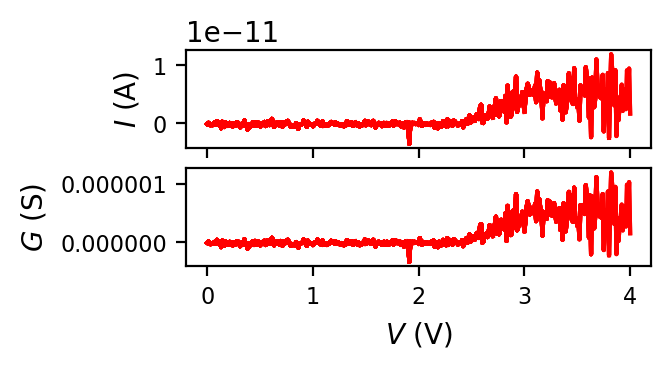

In [31]:
OnOff(-1,0)

Measurement ends.
Source drain goes to zero...
這次量測花費了 114.143113 分鐘
DONE!!!


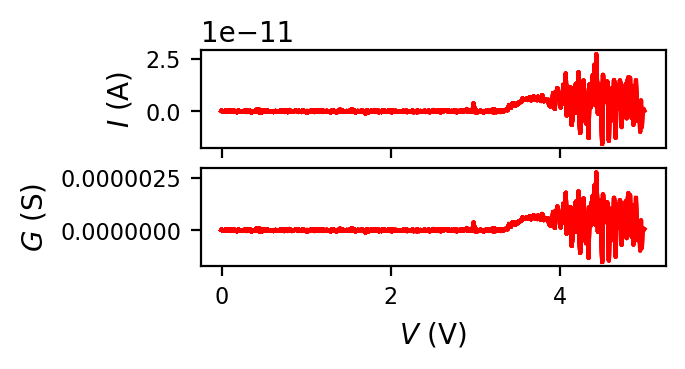

In [35]:
OnOff(-1,1)

Measurement ends.
Source drain goes to zero...
這次量測花費了 123.921576 分鐘
DONE!!!


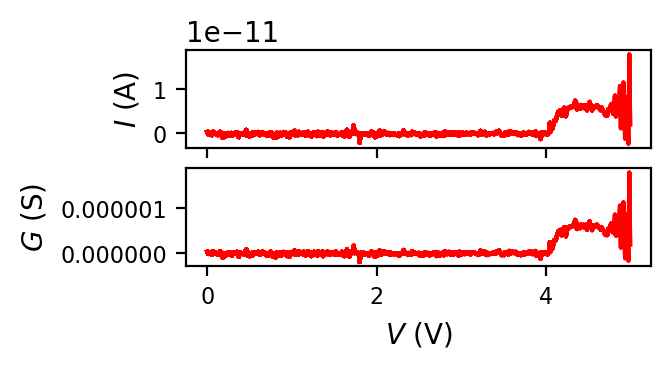

In [36]:
OnOff(-1,2)

## SD1/SD2

Measurement ends.
Source drain goes to zero...
這次量測花費了 113.821341 分鐘
DONE!!!


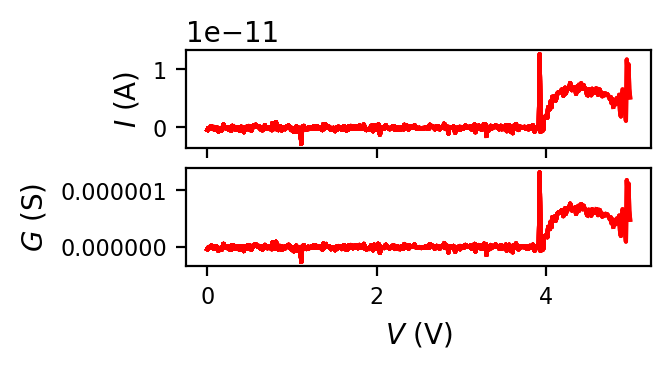

In [13]:
OnOff(-1,0)

Measurement ends.
Source drain goes to zero...
這次量測花費了 124.279324 分鐘
DONE!!!


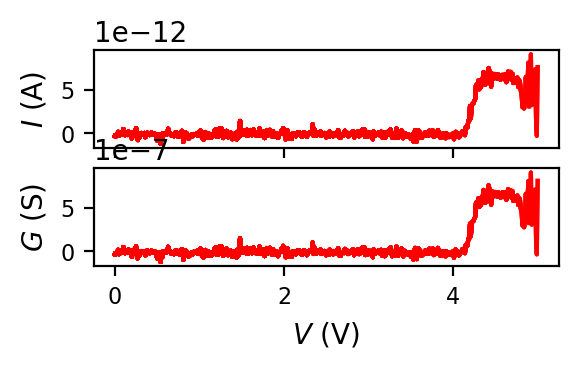

In [14]:
OnOff(-1,1)

Measurement ends.
Source drain goes to zero...
這次量測花費了 123.309074 分鐘
DONE!!!


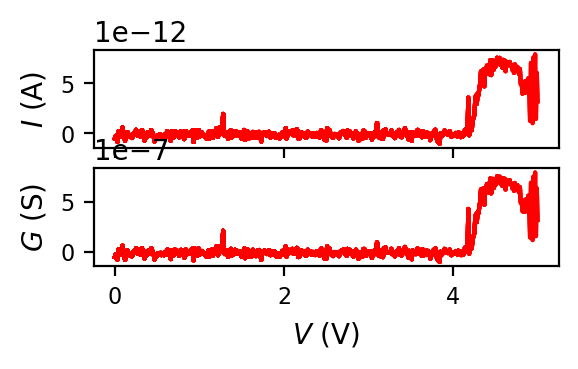

In [15]:
OnOff(-1,2)

## AC=87.11hz 

Measurement ends.
Source drain goes to zero...
這次量測花費了 113.905199 分鐘
DONE!!!


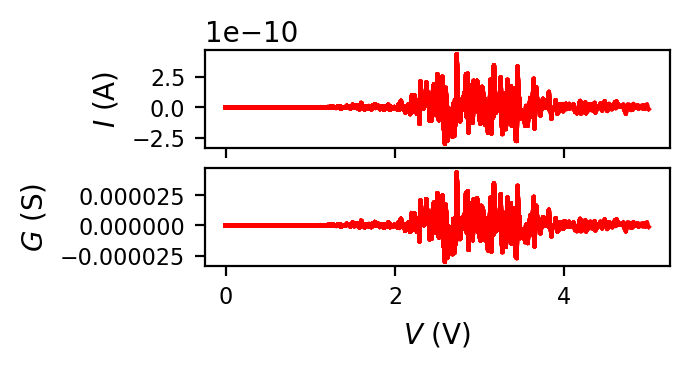

In [13]:
OnOff(-1,0)

Measurement ends.
Source drain goes to zero...
這次量測花費了 122.478304 分鐘
DONE!!!


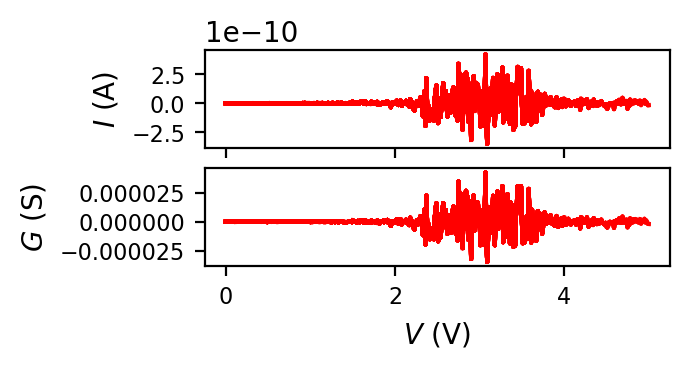

In [14]:
OnOff(-1,1)

Measurement ends.
Source drain goes to zero...
這次量測花費了 123.854685 分鐘
DONE!!!


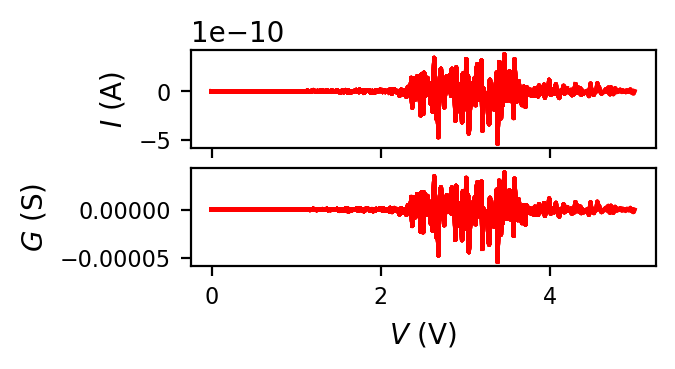

In [15]:
OnOff(-1,2)

## V_dep = -2

Measurement ends.
Source drain goes to zero...
這次量測花費了 115.962077 分鐘
DONE!!!


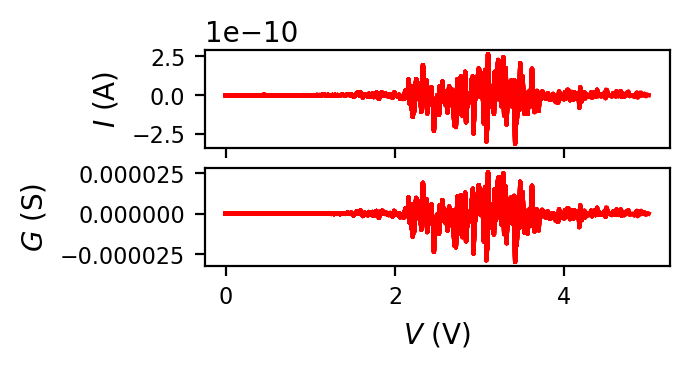

In [19]:
OnOff(-2,0)

Measurement ends.
Source drain goes to zero...
這次量測花費了 126.256435 分鐘
DONE!!!


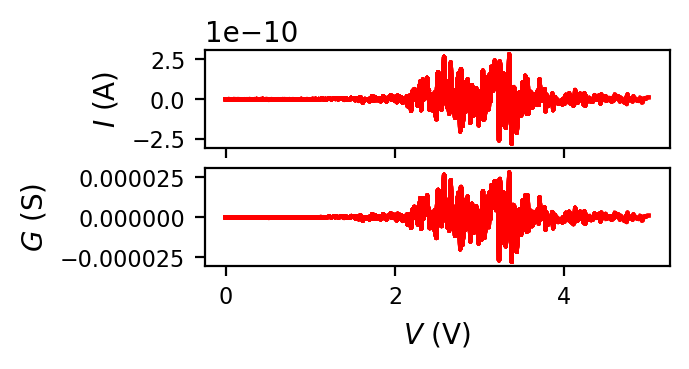

In [20]:
OnOff(-2,1)

Measurement ends.
Source drain goes to zero...
這次量測花費了 126.134453 分鐘
DONE!!!


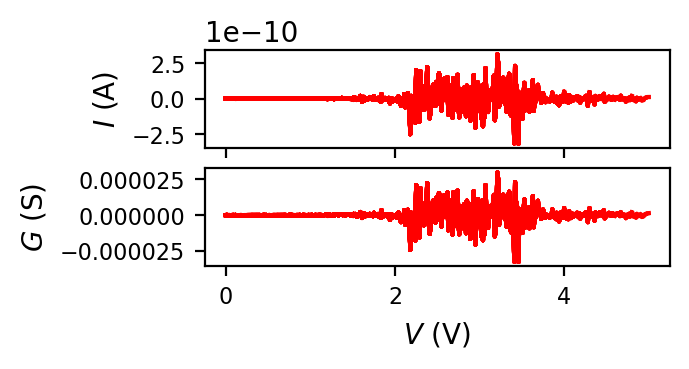

In [21]:
OnOff(-2,2)

##  to 7V

Measurement ends.
Source drain goes to zero...
這次量測花費了 162.995740 分鐘
DONE!!!


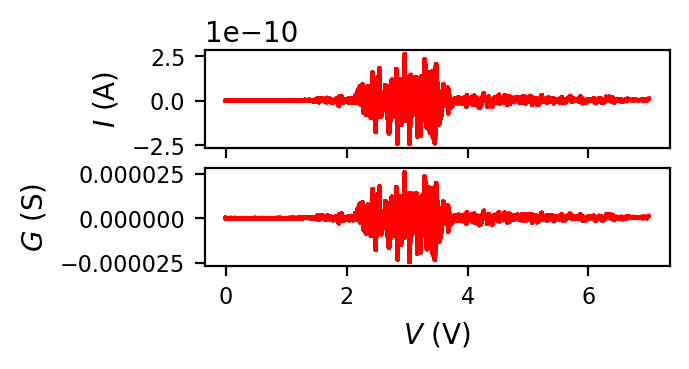

In [27]:
OnOff(-2,0)

Measurement ends.
Source drain goes to zero...
這次量測花費了 158.888516 分鐘
DONE!!!


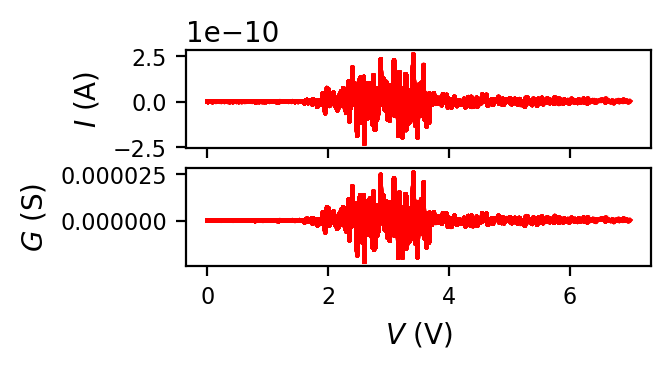

In [28]:
OnOff(-2,1)

In [38]:
gate.v.set(0)

Ramp time too short: 0.000 s. Ramp time set to 2 ms.


In [40]:
gate.v.get()

2e-06